In [2]:
# import dependencies
import os
import pandas as pd
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import re

## SCA Dataset


### Dataset Analysis

In [3]:
full_df = pd.read_csv("instant_approach/original_training_set_filtered.csv")

#### Label Distribution

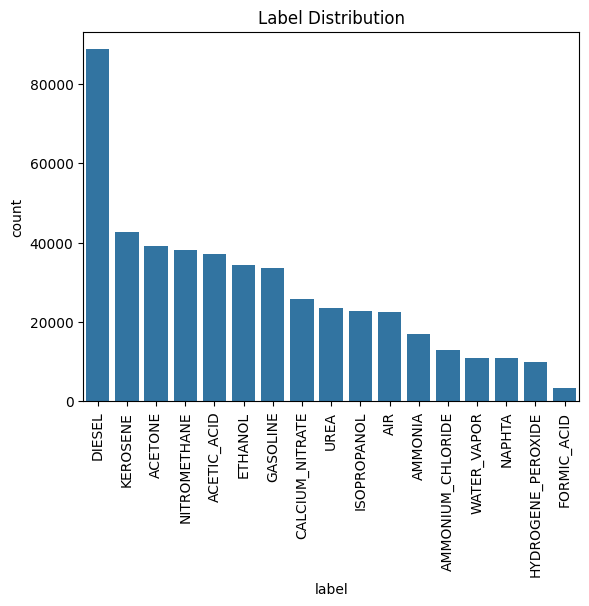

In [6]:
sns.countplot(data=full_df, x="label", order=full_df["label"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Label Distribution")
plt.show()

#### Feature Correlation

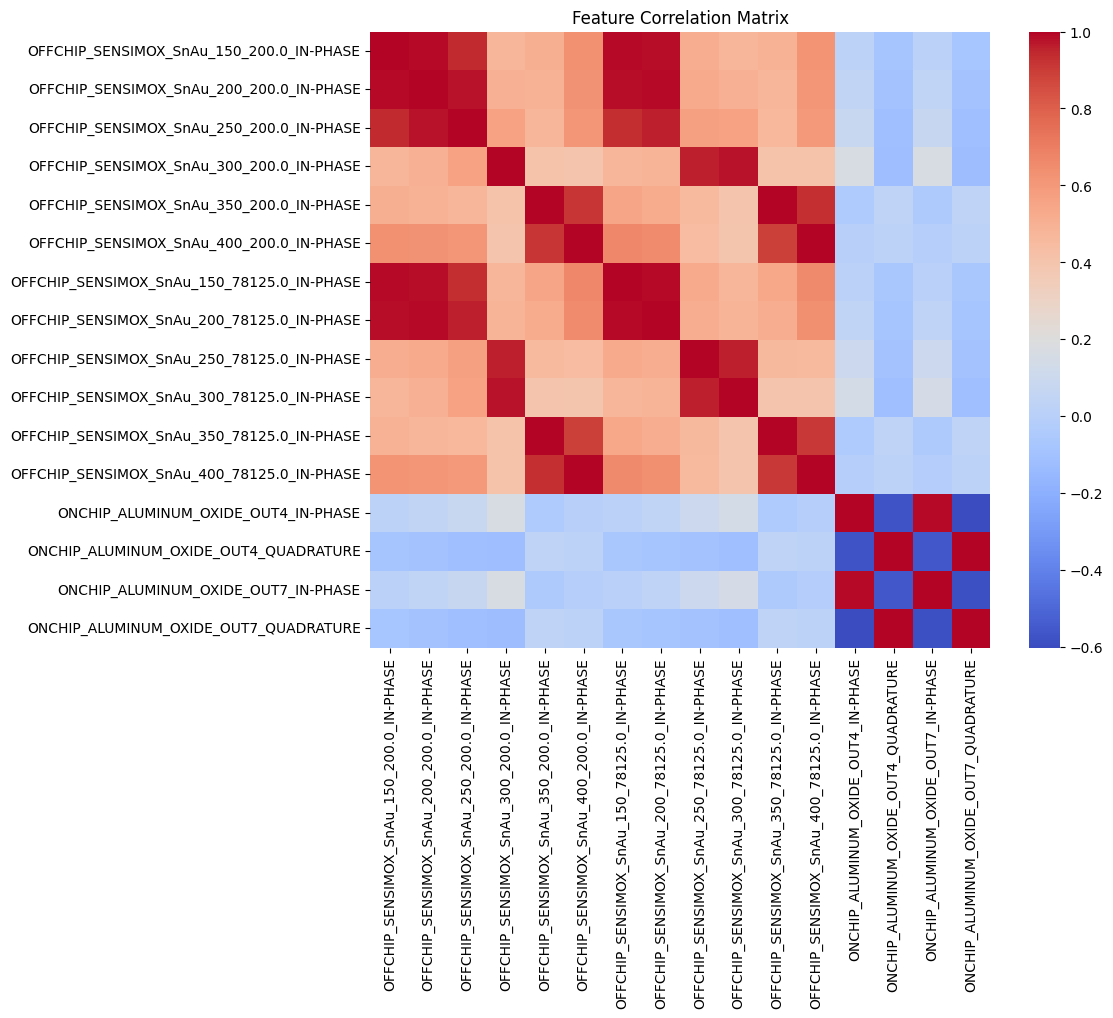

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(full_df.iloc[:, :16].corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

**🔍 Feature Correlation Matrix**

The heatmap shows the correlation between the 16 impedance features of the SCA dataset:

- The **SnO₂+Au sensor features** (left block) show **strong positive correlations** across temperatures and frequencies, indicating similar response patterns under TCO conditions.
- The **Al₂O₃ sensor features** (right block) exhibit **strong internal correlations** (both in-phase and quadrature), but **low or negative correlation** with the SnO₂+Au features, confirming their different sensing behavior under VCO conditions.
- This separation suggests that the two sensor types contribute **complementary information**, useful for multi-sensor classification models.


#### PCA 3D

In [8]:
X = full_df.iloc[:, :16]
y = full_df["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

full_df["PC1"] = X_pca[:, 0]
full_df["PC2"] = X_pca[:, 1]
full_df["PC3"] = X_pca[:, 2]

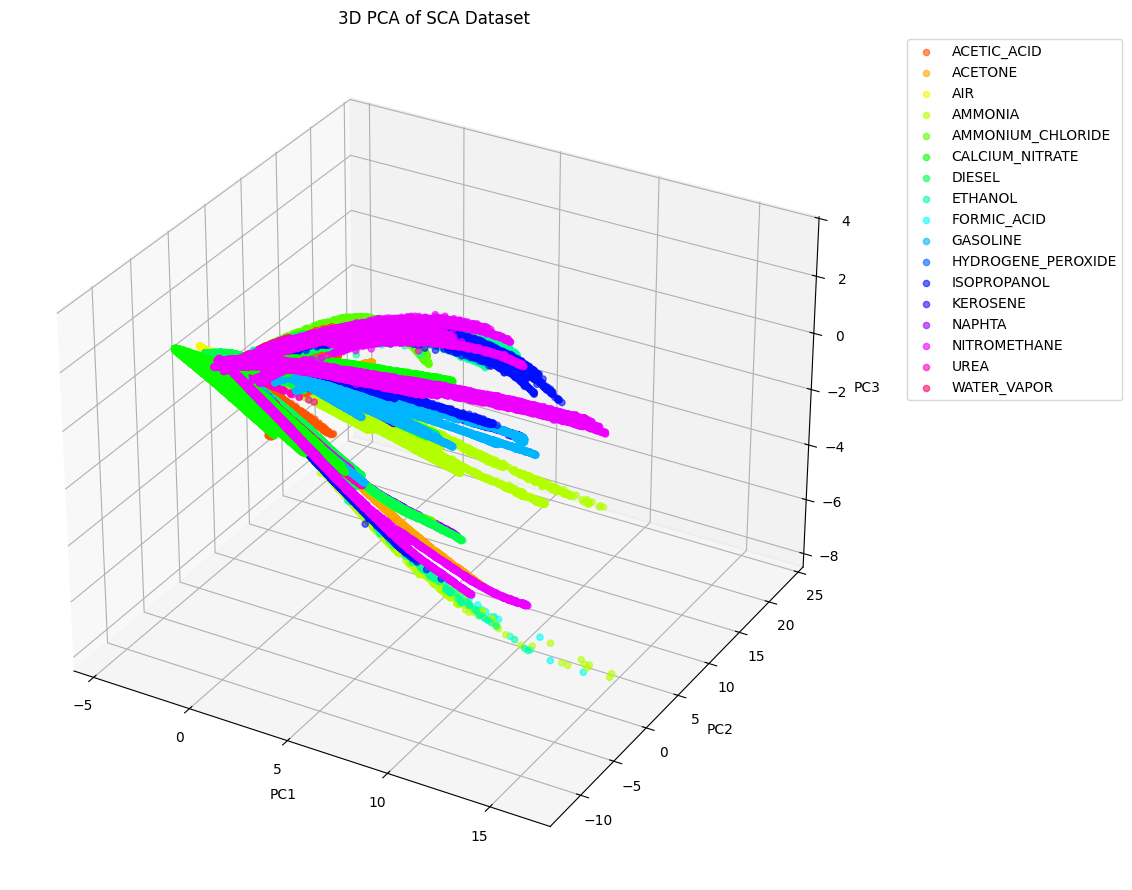

In [9]:
unique_labels = full_df["label"].unique()
palette = sns.color_palette("hsv", len(unique_labels))
color_dict = dict(zip(unique_labels, palette))

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    subset = full_df[full_df["label"] == label]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"],
               label=label, color=color_dict[label], s=20, alpha=0.6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA of SCA Dataset")
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

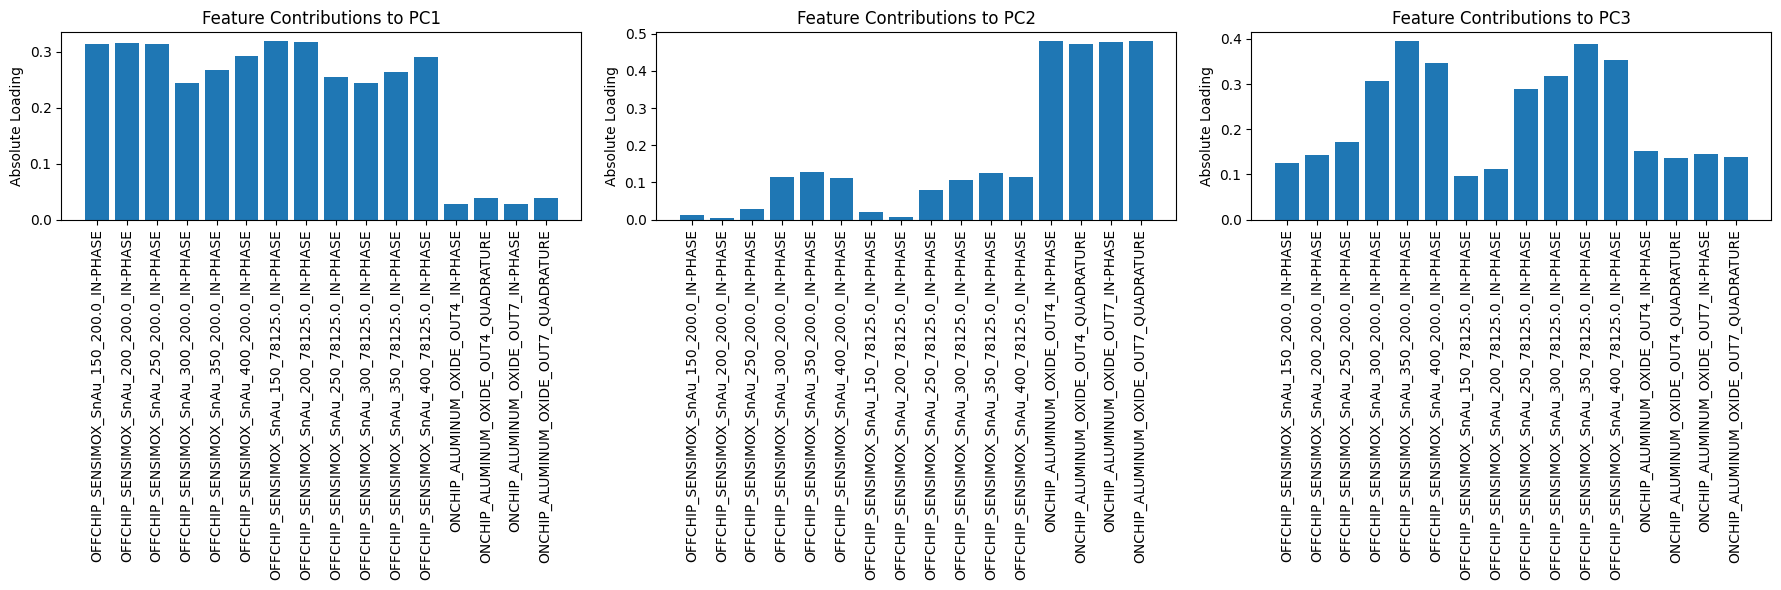

In [10]:
feature_names = full_df.columns[:16]

loadings = pd.DataFrame(pca.components_.T,
                        columns=["PC1", "PC2", "PC3"],
                        index=feature_names)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, pc in enumerate(["PC1", "PC2", "PC3"]):
    axes[i].bar(loadings.index, np.abs(loadings[pc]))
    axes[i].set_title(f"Feature Contributions to {pc}")
    axes[i].set_ylabel("Absolute Loading")
    
    # Fix the tick issue
    axes[i].set_xticks(np.arange(len(loadings.index)))
    axes[i].set_xticklabels(loadings.index, rotation=90)

plt.tight_layout()
plt.show()

## SCW Dataset

**💧 SensiChips – SCW Water Sensor EIS Dataset**

**Date:** February 12, 2024  
**Sensor Type:** SCW water sensor with 5 IDEs  
**Frequencies:** 78.125 kHz & 200 Hz  
**Format:** `.csv`

---

**📊 Data Overview**

This dataset contains **10 impedance measurements** recorded at two AC frequencies (78.125 kHz and 200 Hz) across **five types of Interdigitated Electrodes (IDEs)**:

- **Platinum IDE**  
  - IN-PHASE @ 78.125 kHz  
  - IN-PHASE + QUADRATURE @ 200 Hz

- **Gold IDE**  
  - IN-PHASE @ 78.125 kHz  
  - IN-PHASE + QUADRATURE @ 200 Hz

- **Silver, Nickel, Copper Oxide IDEs**  
  - IN-PHASE + QUADRATURE @ 200 Hz

---

**🧪 Experimental Setup**

- Each experiment simulates the gradual introduction of a **chemical compound into tap water**, allowing the sensor to acquire at least **200 samples** from **low to high concentrations**.
- **15 different chemicals** are tested, each with **at least 10 experiments**.
- These measurements support the training of machine learning models to **classify chemicals based on their concentration**.

---

**📁 Folder Structure**

- `TRAINING/` – Contains controlled experiments for training ML models  
  - `RAW/` – Full 12-channel 16-bit ADC data (`-32768` to `32767`)  
  - `NORMALIZED/` – Baseline-subtracted data vs. tap water  
    - Includes only **10 of 12 measurements** (excludes Copper Oxide IDE)

- `TEST/` – Measurements under **random & turbulent conditions**  
  - Used to **validate** the models in real-world-like scenarios

---

**🧠 Notes**

- The **NORMALIZED** files allow easier pattern recognition by ML models, emphasizing variation from clean water.
- The **TEST** set emulates unpredictable environments to evaluate generalization.

---

For ML use: **classify different chemicals and their concentrations** using impedance signals.


#### Building new DataFrame

In [17]:
# Loop through the directories to find .xlsx files
for split in ['TEST', 'TRAINING']:
    split_dir = os.path.join(SCW_dset_dir, split, "NORMALIZED")

    for label in os.listdir(split_dir):
        label_dir = os.path.join(split_dir, label)

        for filename in os.listdir(label_dir):
            if filename.endswith('.xlsx'):
                file_path = os.path.join(label_dir, filename)

                # Read the .xlsx file
                df = pd.read_excel(file_path)

                # Remove '0000' and 'Unnamed' from column names (if needed)
                df.columns = df.columns.str.replace(r'_0000$', '', regex=True)
                df.columns = df.columns.str.replace('Unnamed: \d+', '', regex=True)

                # Save it as a .csv file
                csv_filename = os.path.splitext(filename)[0] + '.csv'
                csv_file_path = os.path.join(label_dir, csv_filename)
                df.to_csv(csv_file_path, index=False)

                print(f"✅ Converted {filename} to {csv_filename}")

✅ Converted Experiment_29-11-2022_16-36_GLOBAL_TEST_CONC_IN-PHASE.xlsx to Experiment_29-11-2022_16-36_GLOBAL_TEST_CONC_IN-PHASE.csv
✅ Converted Experiment_29-11-2022_18-12_GLOBAL_TEST_CONC_IN-PHASE.xlsx to Experiment_29-11-2022_18-12_GLOBAL_TEST_CONC_IN-PHASE.csv


In [20]:
all_data = []

# ✅ Expected columns base (you can customize if needed)
expected_prefixes = [
    'OFFCHIP_PLATINUM', 'OFFCHIP_GOLD', 'OFFCHIP_SILVER',
    'OFFCHIP_NICKEL', 'LABEL'
]

# 👁 Loop over TEST and TRAINING splits
for split in ['TEST', 'TRAINING']:
    split_dir = os.path.join(SCW_dset_dir, split, "NORMALIZED")
    
    for label in os.listdir(split_dir):
        label_dir = os.path.join(split_dir, label)
        
        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            exp_name = os.path.splitext(filename)[0]

            # ❌ Skip files that are not .csv
            if not filename.endswith('.csv'):
                continue

            try:
                # 📄 Read CSV files (with ; separator)
                df = pd.read_csv(file_path, sep=';')

                # ✅ Clean column names: remove '0000' and handle 'Unnamed' columns
                df.columns = df.columns.str.replace(r'_0000$', '', regex=True)  # Remove '0000' from columns
                df.columns = df.columns.str.replace('Unnamed: \d+', '', regex=True)  # Remove 'Unnamed' columns

                # ✅ Add split and experiment name
                df['SPLIT'] = split
                df['EXP_NAME'] = exp_name

                all_data.append(df)

            except Exception as e:
                print(f"⚠️ Error reading file {file_path}: {e}")

# 🧱 Combine all collected DataFrames
try:
    full_df = pd.concat(all_data, ignore_index=True)
    print("🧩 Concatenation successful.")
except Exception as e:
    print(f"❌ Concatenation failed: {e}")
    raise

# 🔍 NaN analysis
nan_counts = full_df.isna().sum()
threshold = 0.9
cols_to_drop = nan_counts[nan_counts > threshold * len(full_df)].index.tolist()

print(f"🪓 Dropping {len(cols_to_drop)} columns with more than {int(threshold*100)}% NaNs:")
print(cols_to_drop)

df_reduced = full_df.drop(columns=cols_to_drop)

# 🧹 Drop rows only if NaN in key sensor columns
key_columns = [col for col in df_reduced.columns if 'IN-PHASE' in col or 'QUADRATURE' in col or 'LABEL' in col]
df_clean = df_reduced.dropna(subset=key_columns)

# 💾 Save
df_clean.to_csv(os.path.join(SCW_dset_dir, "SCW_dset.csv"), index=False)

# 📊 Final report
print("✅ Cleaned dataset saved.")
print(f"📉 Columns dropped: {len(cols_to_drop)}")
print(f"🧨 Rows deleted (after subset dropna): {full_df.shape[0] - df_clean.shape[0]}")
print(f"📊 Final dataset shape: {df_clean.shape}")

🧩 Concatenation successful.
🪓 Dropping 4 columns with more than 90% NaNs:
['Timestamp [Seconds]', 'OFFCHIP_ORP_0000 [mVolt]', 'ONCHIP_TEMPERATURE_0000 [Celsius]', '']
✅ Cleaned dataset saved.
📉 Columns dropped: 4
🧨 Rows deleted (after subset dropna): 0
📊 Final dataset shape: (191482, 13)


### Dataset Analysis

In [ ]:
full_df = pd.read_csv(os.path.join(SCW_dset_dir, "SCW_dset.csv"))

#### Label Distribution

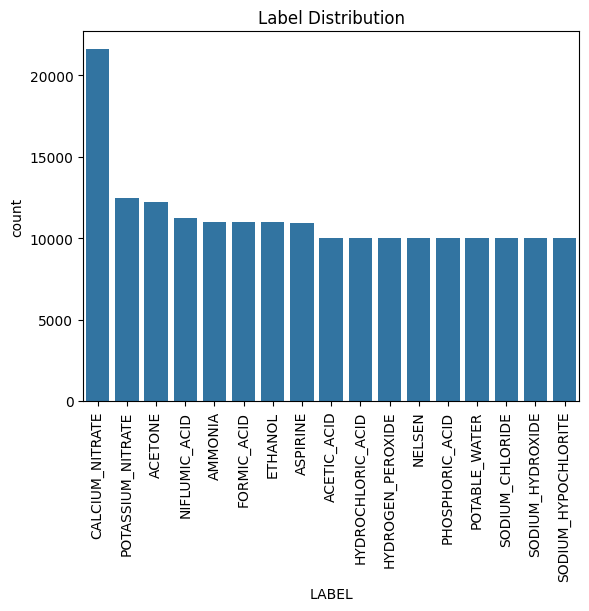

In [23]:
sns.countplot(data=full_df, x="LABEL", order=full_df["LABEL"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Label Distribution")
plt.show()

#### Feature Correlation

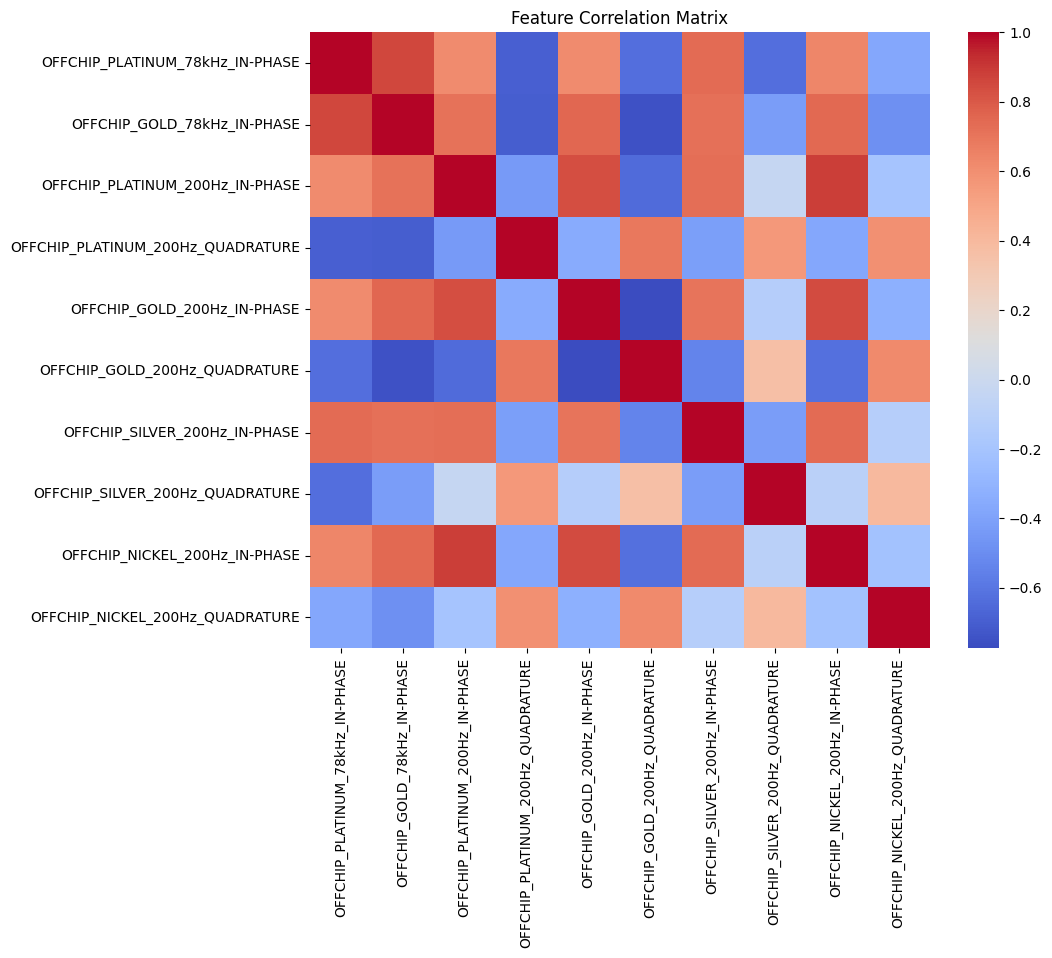

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(full_df.iloc[:, :10].corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

**🔬 Feature Correlation Matrix (Metal Sensors Dataset)**

This heatmap highlights the correlations among features extracted from platinum, gold, silver, and nickel sensors at 200Hz and 78kHz:

- **Same-material features** (e.g., Platinum or Gold at different frequencies) generally show **moderate to high positive correlation**, indicating consistent behavior across in-phase and quadrature components.
- **Cross-material correlations** are more variable, with **weak or even negative correlations**, especially between sensors like Platinum and Silver or Gold and Nickel.
- The **quadrature components** often display **lower correlation** with in-phase signals, reflecting their distinct impedance characteristics.

These patterns suggest that each material contributes unique information, which is useful for building models with enhanced discriminative power.


#### PCA 3D

In [24]:
X = full_df.iloc[:, :10]
y = full_df["LABEL"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

full_df["PC1"] = X_pca[:, 0]
full_df["PC2"] = X_pca[:, 1]
full_df["PC3"] = X_pca[:, 2]

full_df.to_csv(os.path.join(SCW_dset_dir, "SCW_dset.csv"), index=False)
print("✅ Dataset saved with PCA components in 'SCW_dset.csv'")

✅ Dataset saved with PCA components in 'SCW_dset.csv'


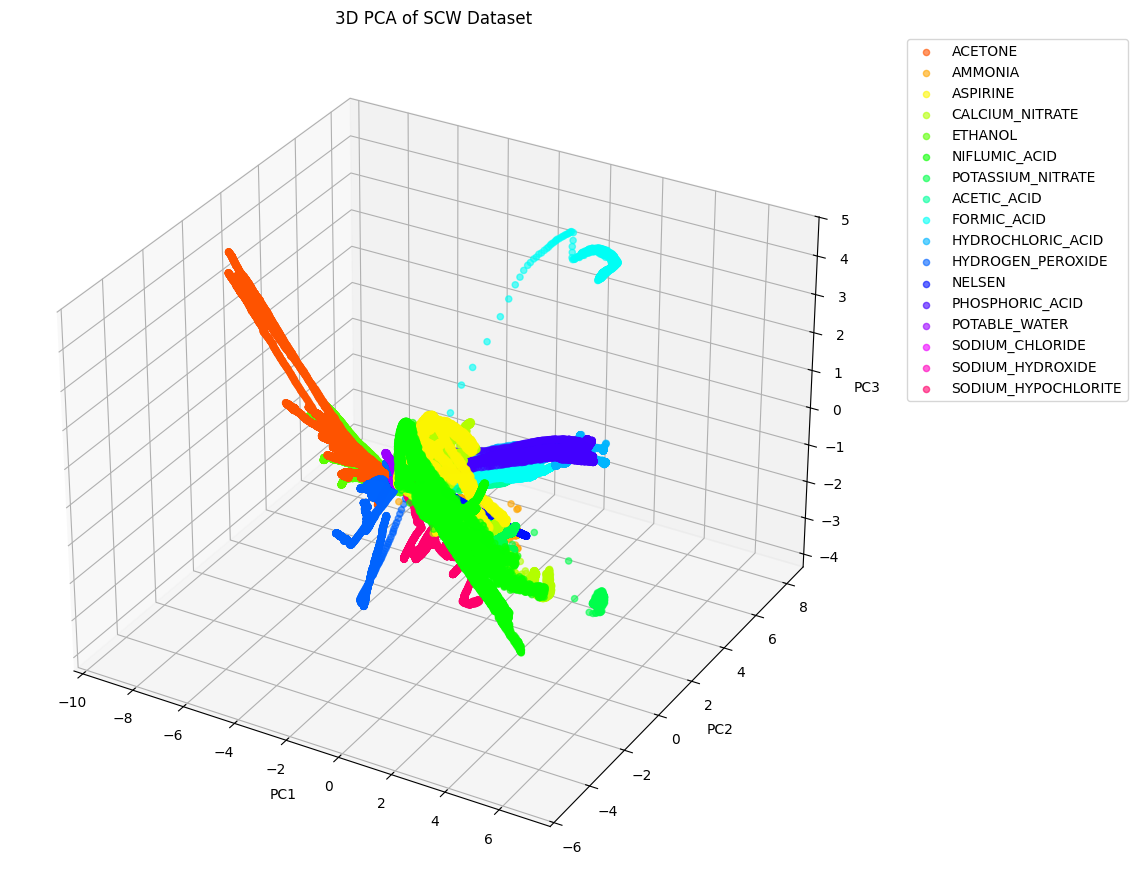

In [25]:
unique_labels = full_df["LABEL"].unique()
palette = sns.color_palette("hsv", len(unique_labels))
color_dict = dict(zip(unique_labels, palette))

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    subset = full_df[full_df["LABEL"] == label]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"],
               label=label, color=color_dict[label], s=20, alpha=0.6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA of SCW Dataset")
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

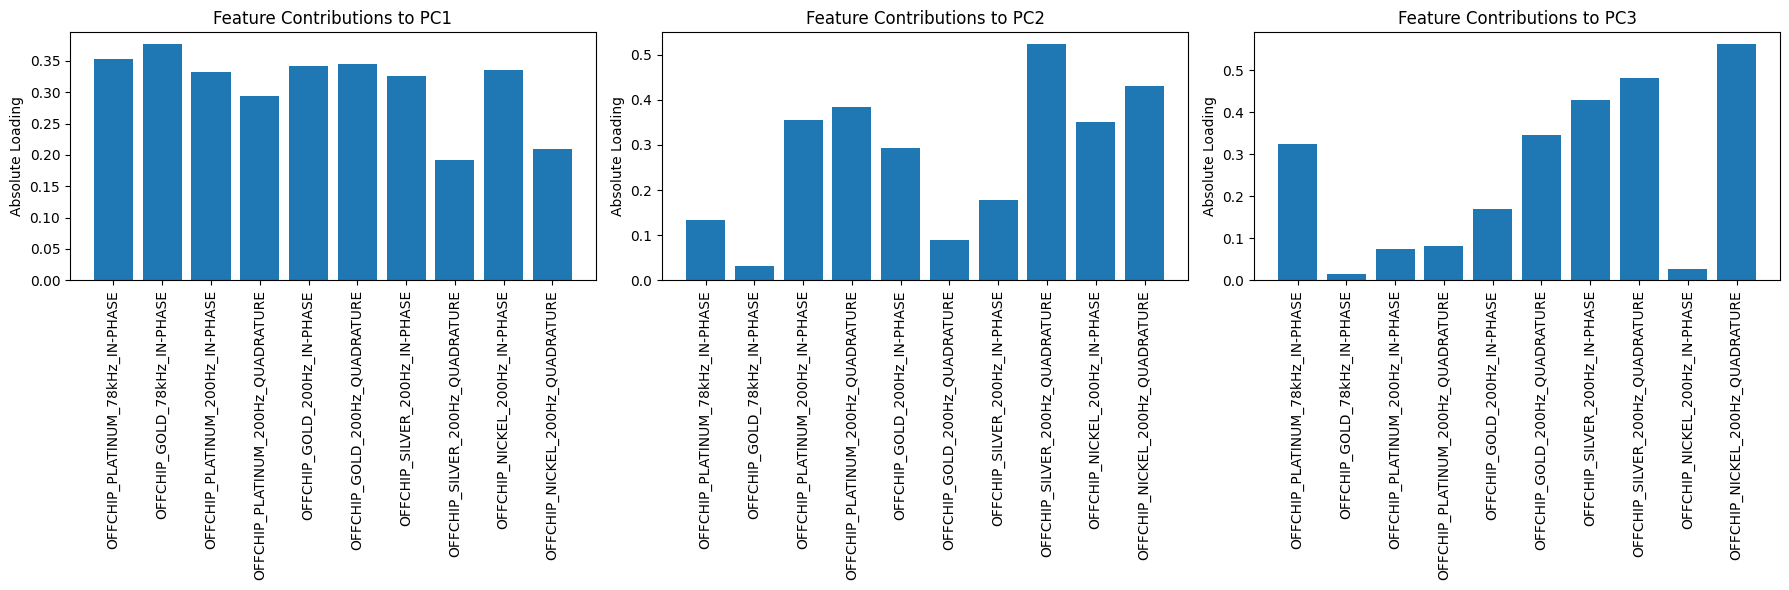

In [26]:
feature_names = full_df.columns[:10]

loadings = pd.DataFrame(pca.components_.T,
                        columns=["PC1", "PC2", "PC3"],
                        index=feature_names)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, pc in enumerate(["PC1", "PC2", "PC3"]):
    axes[i].bar(loadings.index, np.abs(loadings[pc]))
    axes[i].set_title(f"Feature Contributions to {pc}")
    axes[i].set_ylabel("Absolute Loading")
    
    # Fix the tick issue
    axes[i].set_xticks(np.arange(len(loadings.index)))
    axes[i].set_xticklabels(loadings.index, rotation=90)

plt.tight_layout()
plt.show()